# Frequenzsweep

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import linecache
from scipy.signal import find_peaks

In [7]:
class Oszi:
    def __init__(self,path):
        '''Path ohne Endung angeben.'''
        data = np.genfromtxt(path).T
        self.path = path
        self.scope = path + '_ScopeSettings.txt'
        self.time = data[0]
        self.ch1 = data[1]
        self.ch2 = data[2]

    def plot(self,xlabel=None,ylabel1=None,ylabel2=None,title=None,figsize=(8,5),ScopeSettings=False):
        '''ScopeSettings gibt an, ob Oszi-Fenster wie im Praktikum dargestellt werden soll.'''
        fig, ax1 = plt.subplots(figsize=figsize)
        ax2 = ax1.twinx()
        if ScopeSettings == True:
            '''Bin mir nicht ganz sicher, ob das so passt. Wahrscheinliche automatische Anpassung besser'''
            offset1 = float(linecache.getline(self.scope,3).split()[1])
            # scale1 = float(linecache.getline(self.scope,2).split()[1])
            offset2 = float(linecache.getline(self.scope,11).split()[1])
            # scale2 = float(linecache.getline(self.scope,10).split()[1])
            print(offset1)
            print(offset2)
            ax1.plot(self.time,self.ch1+offset1,label='Channel 1',color='blue')
            ax2.plot(self.time,self.ch2+offset2,label='Channel 2',color='red')
            ax1.legend(loc=2)
            ax2.legend(loc=3)
            ax1.tick_params(axis='y', labelcolor='blue')
            ax2.tick_params(axis='y', labelcolor='red')
        else:
            ax1.plot(self.time,self.ch1,label='Channel 1',color='blue')
            ax2.plot(self.time,self.ch2,label='Channel 2',color='red')
            ax1.legend(loc=2)
            ax2.legend(loc=3)
            ax1.tick_params(axis='y', labelcolor='blue')
            ax2.tick_params(axis='y', labelcolor='red')
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel1,c='blue')
        ax2.set_ylabel(ylabel2,c='red')
        plt.title(title)
        return fig, ax1, ax2

def helmholtz(N,r,I):
    '''Rückgabe der magnetischen Flussdichte'''
    return (4/5)**(3/2)*N/r*I

R = 1/0.5806117775757463
N = 160
r = 9e-2

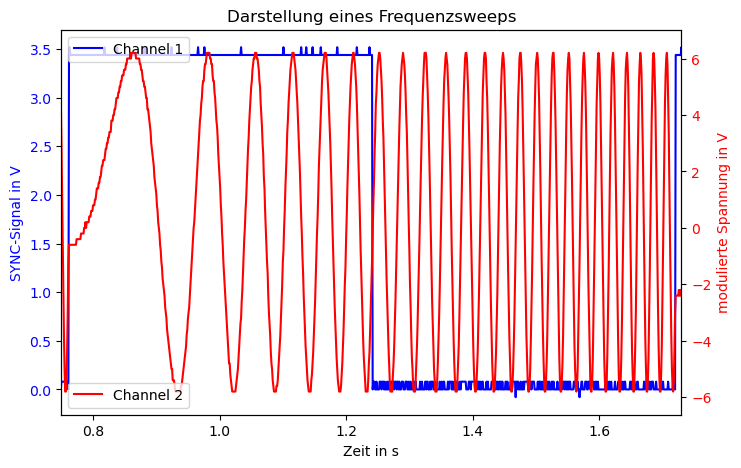

In [29]:
test = Oszi('data/g_faktor/f_sweep/sync_test')
fig, ax1, ax2 = test.plot(title='Darstellung eines Frequenzsweeps',xlabel='Zeit in s',ylabel1='SYNC-Signal in V',ylabel2='modulierte Spannung in V')
plt.xlim(0.75,1.73)
plt.savefig('figures/frequenzsweep.pdf')

Messung für 25 V fehlt!!!

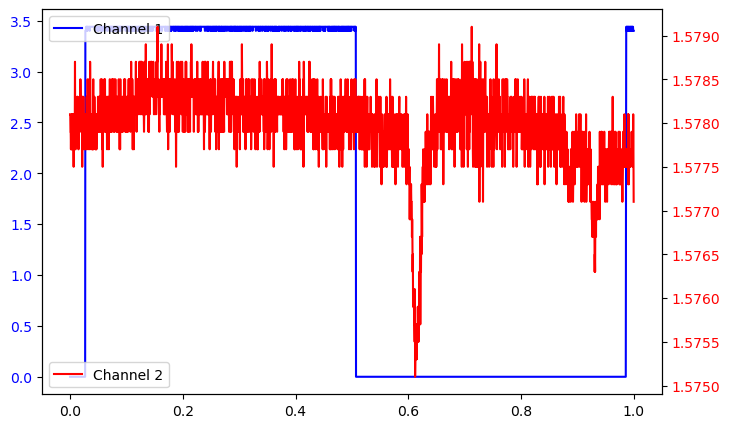

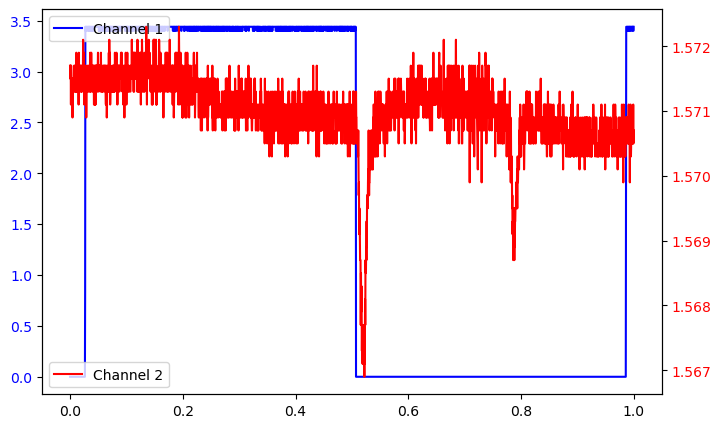

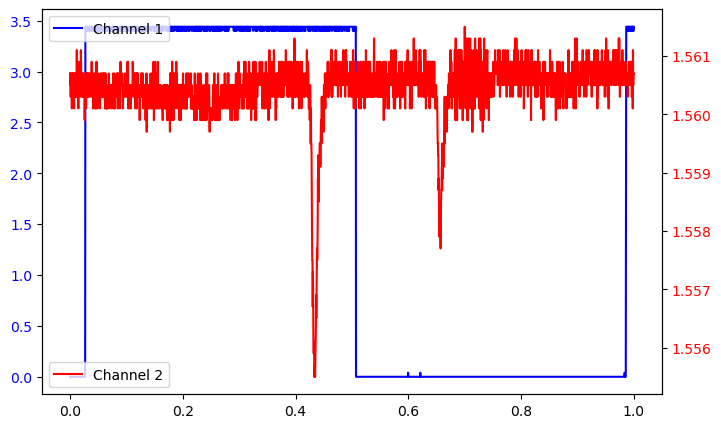

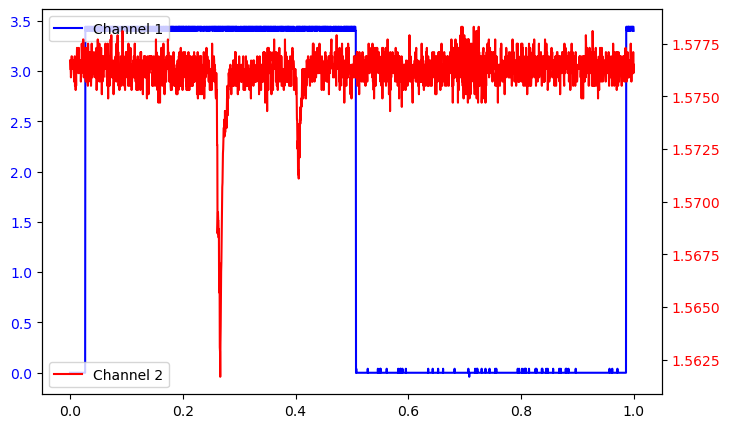

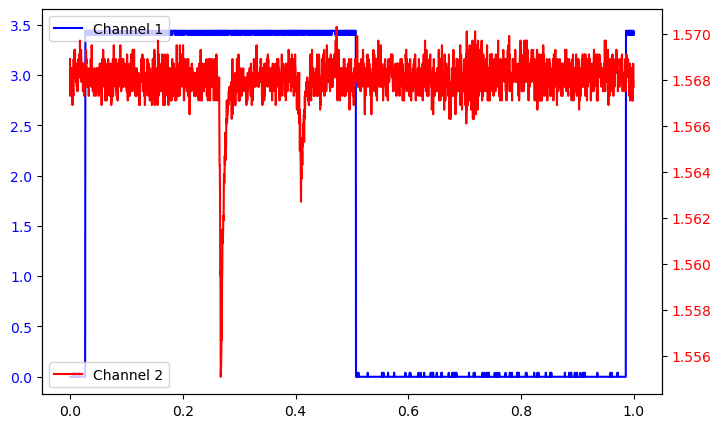

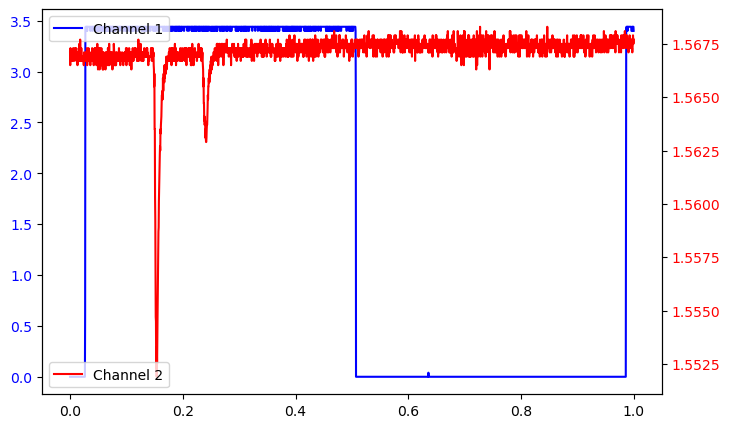

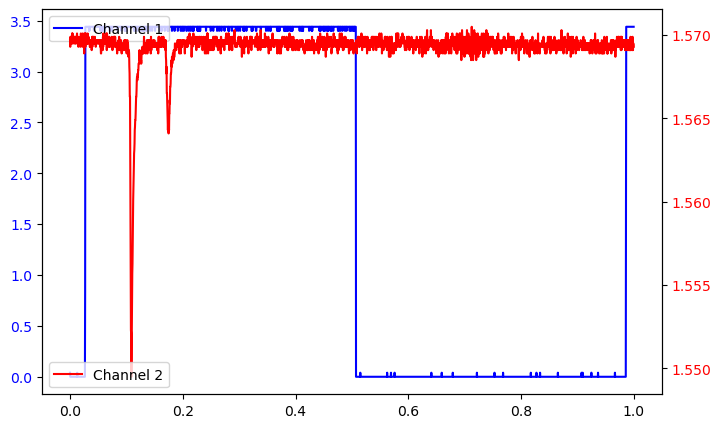

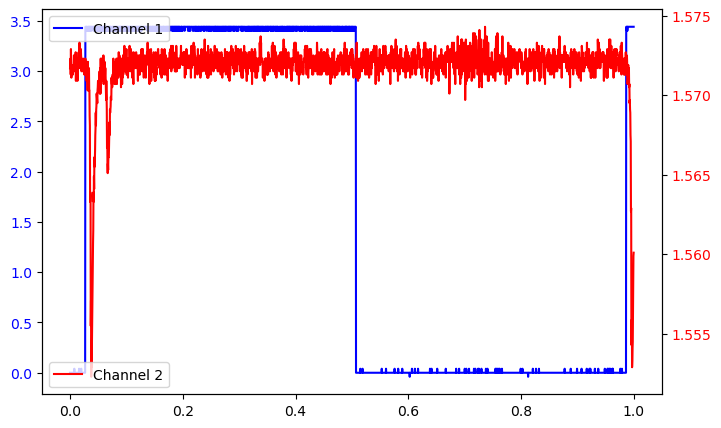

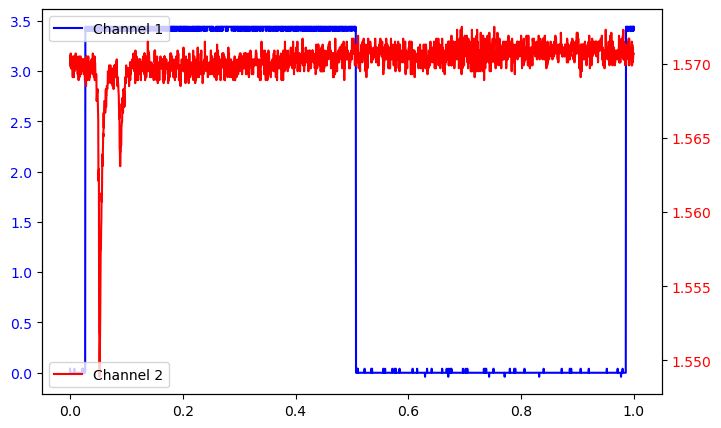

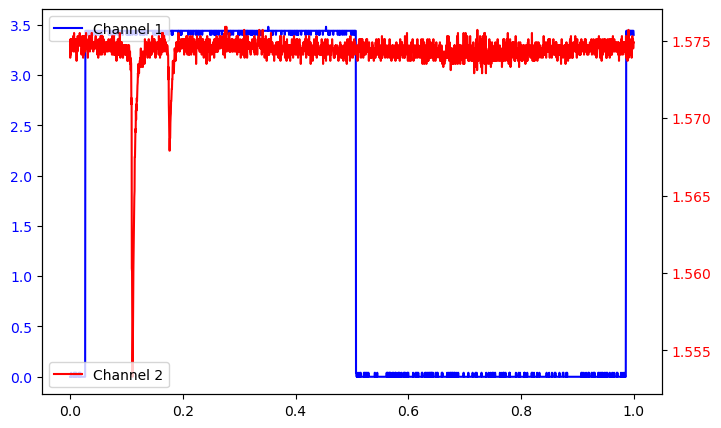

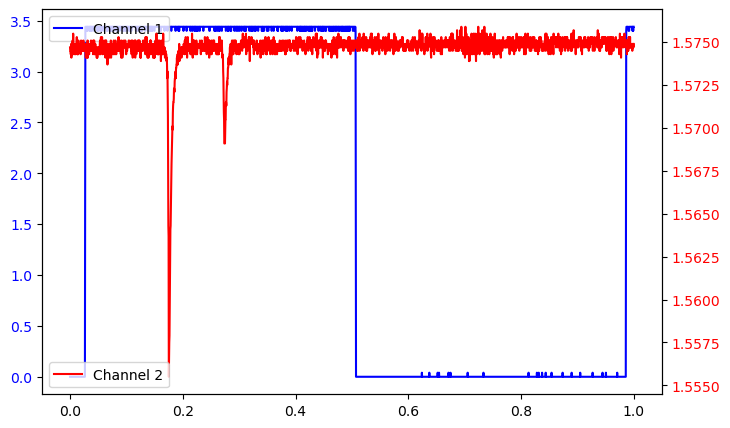

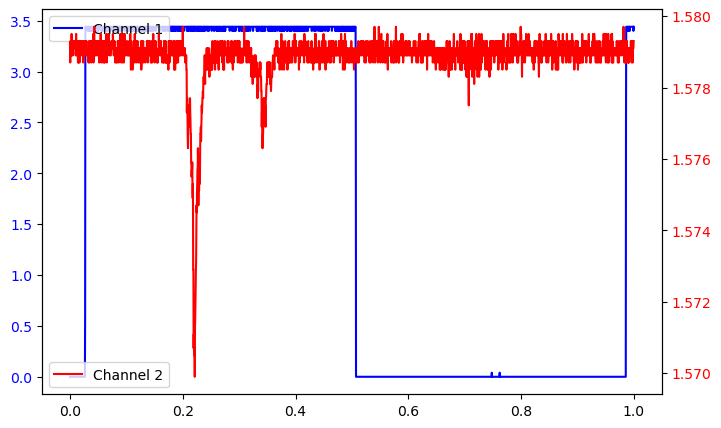

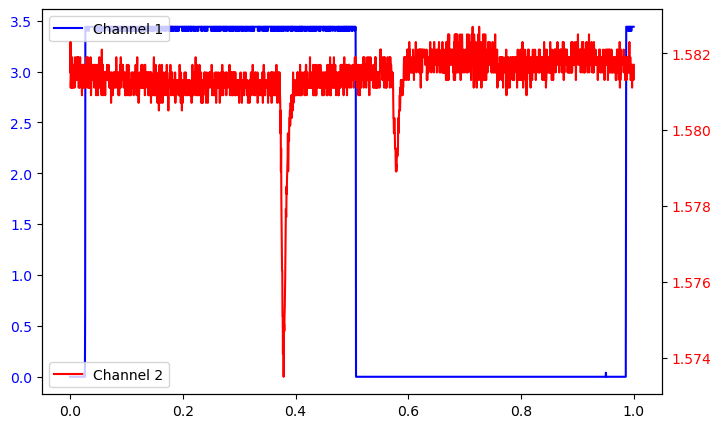

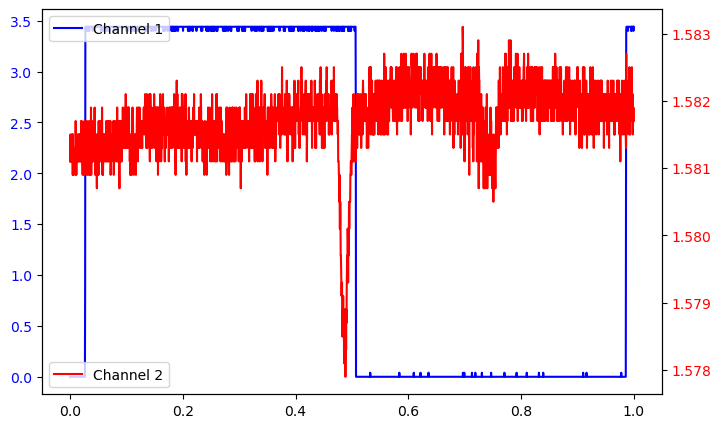

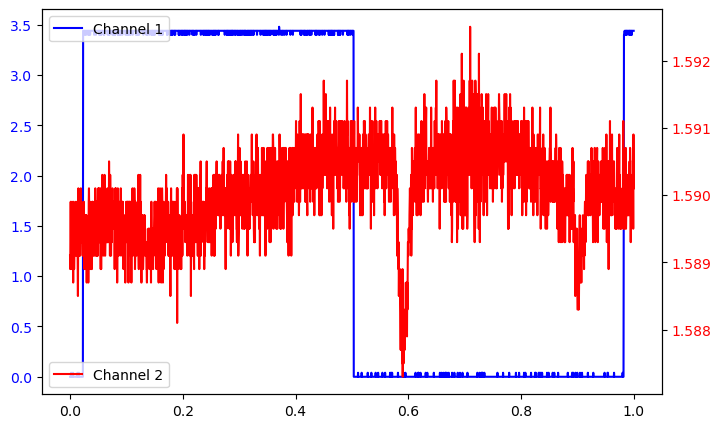

In [33]:
B1 = [40,35,30,25,20,15,10]
B2 = [10,15,20,30,35,40]
sweep = [Oszi(f'data/g_faktor/f_sweep/-{i}V') for i in B1] + [Oszi('data/g_faktor/f_sweep/-05V'),Oszi('data/g_faktor/f_sweep/05V')] + [Oszi(f'data/g_faktor/f_sweep/{i}V') for i in B2]

for i in sweep:
    i.plot()